# Transformer Architecture: The Attention Mechanism

## 1. Introduction

The **Transformer** architecture, introduced by Vaswani et al. in the seminal paper *"Attention Is All You Need"* (2017), revolutionized sequence-to-sequence modeling by eliminating recurrence entirely in favor of **self-attention mechanisms**. This notebook provides a rigorous mathematical treatment of the attention mechanism and implements it from scratch.

## 2. Theoretical Foundation

### 2.1 The Attention Function

The core idea of attention is to compute a weighted sum of **values** $V$, where the weights are determined by the compatibility between **queries** $Q$ and **keys** $K$.

Given:
- Query matrix $Q \in \mathbb{R}^{n \times d_k}$
- Key matrix $K \in \mathbb{R}^{m \times d_k}$
- Value matrix $V \in \mathbb{R}^{m \times d_v}$

The **Scaled Dot-Product Attention** is defined as:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

where $d_k$ is the dimension of the keys (and queries).

### 2.2 Why Scale by $\sqrt{d_k}$?

For large values of $d_k$, the dot products $q_i \cdot k_j$ can grow large in magnitude. If we assume that the components of $q$ and $k$ are independent random variables with mean 0 and variance 1, then:

$$\mathbb{E}[q \cdot k] = 0, \quad \text{Var}(q \cdot k) = d_k$$

Large variances push the softmax into regions where gradients are extremely small (saturation). Scaling by $\sqrt{d_k}$ normalizes the variance to 1:

$$\text{Var}\left(\frac{q \cdot k}{\sqrt{d_k}}\right) = 1$$

### 2.3 Multi-Head Attention

Rather than performing a single attention function, Multi-Head Attention allows the model to jointly attend to information from different representation subspaces:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O$$

where each head is computed as:

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

with learned projection matrices:
- $W_i^Q \in \mathbb{R}^{d_{\text{model}} \times d_k}$
- $W_i^K \in \mathbb{R}^{d_{\text{model}} \times d_k}$
- $W_i^V \in \mathbb{R}^{d_{\text{model}} \times d_v}$
- $W^O \in \mathbb{R}^{hd_v \times d_{\text{model}}}$

### 2.4 Self-Attention

In **self-attention**, the queries, keys, and values all come from the same source sequence. For an input sequence $X \in \mathbb{R}^{n \times d_{\text{model}}}$:

$$Q = XW^Q, \quad K = XW^K, \quad V = XW^V$$

This allows each position in the sequence to attend to all other positions, capturing long-range dependencies without the sequential bottleneck of RNNs.

## 3. Implementation

We now implement the attention mechanism from scratch using NumPy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

def softmax(x, axis=-1):
    """Compute softmax values along the specified axis."""
    # Subtract max for numerical stability
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Compute Scaled Dot-Product Attention.
    
    Parameters:
    -----------
    Q : ndarray of shape (batch, seq_len_q, d_k)
        Query matrix
    K : ndarray of shape (batch, seq_len_k, d_k)
        Key matrix
    V : ndarray of shape (batch, seq_len_k, d_v)
        Value matrix
    mask : ndarray, optional
        Mask to apply (e.g., for causal attention)
    
    Returns:
    --------
    output : ndarray of shape (batch, seq_len_q, d_v)
        Attention output
    attention_weights : ndarray of shape (batch, seq_len_q, seq_len_k)
        Attention weights
    """
    d_k = Q.shape[-1]
    
    # Compute attention scores: (batch, seq_len_q, seq_len_k)
    scores = np.matmul(Q, K.transpose(0, 2, 1)) / np.sqrt(d_k)
    
    # Apply mask if provided
    if mask is not None:
        scores = np.where(mask == 0, -1e9, scores)
    
    # Compute attention weights
    attention_weights = softmax(scores, axis=-1)
    
    # Compute output
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

print("Scaled Dot-Product Attention function defined.")

Scaled Dot-Product Attention function defined.


### 3.1 Example: Self-Attention on a Simple Sequence

Let us create a synthetic sequence and visualize how self-attention works.

In [2]:
# Define dimensions
batch_size = 1
seq_len = 6
d_model = 8
d_k = d_v = 4  # Dimension of keys/queries and values

# Create a synthetic input sequence (could represent word embeddings)
X = np.random.randn(batch_size, seq_len, d_model)

# Initialize projection matrices for self-attention
W_Q = np.random.randn(d_model, d_k) * 0.1
W_K = np.random.randn(d_model, d_k) * 0.1
W_V = np.random.randn(d_model, d_v) * 0.1

# Project input to Q, K, V
Q = np.matmul(X, W_Q)
K = np.matmul(X, W_K)
V = np.matmul(X, W_V)

print(f"Input shape: {X.shape}")
print(f"Q shape: {Q.shape}")
print(f"K shape: {K.shape}")
print(f"V shape: {V.shape}")

Input shape: (1, 6, 8)
Q shape: (1, 6, 4)
K shape: (1, 6, 4)
V shape: (1, 6, 4)


In [3]:
# Compute self-attention
output, attention_weights = scaled_dot_product_attention(Q, K, V)

print(f"Attention output shape: {output.shape}")
print(f"Attention weights shape: {attention_weights.shape}")
print(f"\nAttention weights (sum to 1 along last axis):")
print(f"Row sums: {attention_weights[0].sum(axis=-1)}")

Attention output shape: (1, 6, 4)
Attention weights shape: (1, 6, 6)

Attention weights (sum to 1 along last axis):
Row sums: [1. 1. 1. 1. 1. 1.]


## 4. Multi-Head Attention Implementation

In [4]:
class MultiHeadAttention:
    """
    Multi-Head Attention mechanism.
    
    Parameters:
    -----------
    d_model : int
        Model dimension
    num_heads : int
        Number of attention heads
    """
    
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # Initialize projection matrices
        scale = np.sqrt(2.0 / (d_model + self.d_k))
        self.W_Q = np.random.randn(d_model, d_model) * scale
        self.W_K = np.random.randn(d_model, d_model) * scale
        self.W_V = np.random.randn(d_model, d_model) * scale
        self.W_O = np.random.randn(d_model, d_model) * scale
    
    def split_heads(self, x):
        """Split the last dimension into (num_heads, d_k)."""
        batch_size, seq_len, _ = x.shape
        x = x.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        return x.transpose(0, 2, 1, 3)  # (batch, heads, seq_len, d_k)
    
    def combine_heads(self, x):
        """Combine heads back to original shape."""
        batch_size, _, seq_len, _ = x.shape
        x = x.transpose(0, 2, 1, 3)  # (batch, seq_len, heads, d_k)
        return x.reshape(batch_size, seq_len, self.d_model)
    
    def forward(self, Q, K, V, mask=None):
        """
        Forward pass of Multi-Head Attention.
        
        Returns:
        --------
        output : ndarray
            Multi-head attention output
        attention_weights : ndarray
            Attention weights for each head
        """
        # Linear projections
        Q = np.matmul(Q, self.W_Q)
        K = np.matmul(K, self.W_K)
        V = np.matmul(V, self.W_V)
        
        # Split into multiple heads
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # Scaled dot-product attention for each head
        d_k = Q.shape[-1]
        scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / np.sqrt(d_k)
        
        if mask is not None:
            scores = np.where(mask == 0, -1e9, scores)
        
        attention_weights = softmax(scores, axis=-1)
        attention_output = np.matmul(attention_weights, V)
        
        # Combine heads
        output = self.combine_heads(attention_output)
        
        # Final linear projection
        output = np.matmul(output, self.W_O)
        
        return output, attention_weights

print("MultiHeadAttention class defined.")

MultiHeadAttention class defined.


In [5]:
# Test Multi-Head Attention
d_model = 64
num_heads = 8
seq_len = 10
batch_size = 2

# Create input
X = np.random.randn(batch_size, seq_len, d_model)

# Initialize and run multi-head attention
mha = MultiHeadAttention(d_model, num_heads)
output, attn_weights = mha.forward(X, X, X)  # Self-attention

print(f"Input shape: {X.shape}")
print(f"Output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"  (batch, heads, seq_len_q, seq_len_k)")

Input shape: (2, 10, 64)
Output shape: (2, 10, 64)
Attention weights shape: (2, 8, 10, 10)
  (batch, heads, seq_len_q, seq_len_k)


## 5. Causal (Masked) Attention

In autoregressive models (like GPT), we use **causal masking** to prevent positions from attending to subsequent positions. This ensures that the prediction for position $i$ can only depend on known outputs at positions less than $i$.

The causal mask is a lower-triangular matrix:

$$M_{ij} = \begin{cases} 1 & \text{if } j \leq i \\ 0 & \text{if } j > i \end{cases}$$

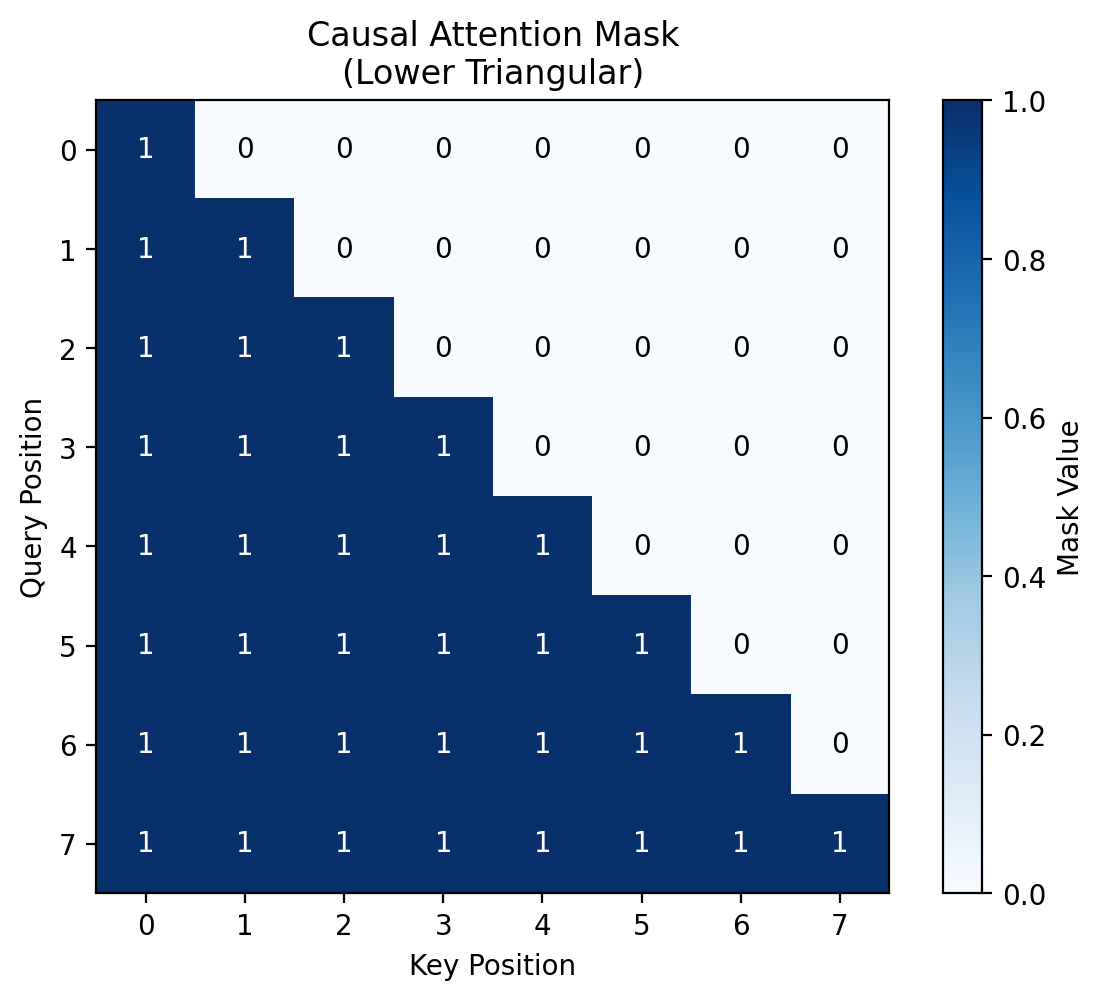

In [6]:
def create_causal_mask(seq_len):
    """Create a causal (lower-triangular) mask."""
    mask = np.tril(np.ones((seq_len, seq_len)))
    return mask

# Visualize causal mask
seq_len = 8
causal_mask = create_causal_mask(seq_len)

plt.figure(figsize=(6, 5))
plt.imshow(causal_mask, cmap='Blues')
plt.colorbar(label='Mask Value')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Causal Attention Mask\n(Lower Triangular)')
plt.xticks(range(seq_len))
plt.yticks(range(seq_len))
for i in range(seq_len):
    for j in range(seq_len):
        plt.text(j, i, int(causal_mask[i, j]), ha='center', va='center', 
                 color='white' if causal_mask[i, j] > 0.5 else 'black')
plt.tight_layout()
plt.show()

In [7]:
# Demonstrate causal attention
batch_size = 1
seq_len = 6
d_k = d_v = 4

Q = np.random.randn(batch_size, seq_len, d_k)
K = np.random.randn(batch_size, seq_len, d_k)
V = np.random.randn(batch_size, seq_len, d_v)

# Create causal mask
causal_mask = create_causal_mask(seq_len)

# Compute attention with and without mask
output_unmasked, weights_unmasked = scaled_dot_product_attention(Q, K, V)
output_masked, weights_masked = scaled_dot_product_attention(Q, K, V, mask=causal_mask)

print("Unmasked attention weights (row 0 attends to all):")
print(weights_unmasked[0, 0, :].round(3))
print("\nMasked attention weights (row 0 only attends to position 0):")
print(weights_masked[0, 0, :].round(3))
print("\nMasked attention weights (last row attends to all previous):")
print(weights_masked[0, -1, :].round(3))

Unmasked attention weights (row 0 attends to all):
[0.115 0.136 0.161 0.061 0.035 0.493]

Masked attention weights (row 0 only attends to position 0):
[1. 0. 0. 0. 0. 0.]

Masked attention weights (last row attends to all previous):
[0.126 0.116 0.233 0.099 0.385 0.042]


## 6. Visualization of Attention Patterns

Let us create a comprehensive visualization comparing attention patterns.

In [8]:
# Create a more structured example with interpretable patterns
np.random.seed(123)

# Simulate a sentence-like sequence with token labels
tokens = ['The', 'cat', 'sat', 'on', 'the', 'mat', '.', '<EOS>']
seq_len = len(tokens)
d_model = 32
num_heads = 4

# Create embeddings (in practice, these would be learned)
# We add some structure: similar words have similar embeddings
embeddings = np.random.randn(seq_len, d_model) * 0.5
# Make 'The' and 'the' similar
embeddings[4] = embeddings[0] + np.random.randn(d_model) * 0.1
# Make punctuation distinct
embeddings[6] = np.random.randn(d_model) * 2
embeddings[7] = np.random.randn(d_model) * 2

X = embeddings.reshape(1, seq_len, d_model)

# Run multi-head attention
mha = MultiHeadAttention(d_model, num_heads)
output, attn_weights = mha.forward(X, X, X)

print(f"Tokens: {tokens}")
print(f"Attention weights shape: {attn_weights.shape}")

Tokens: ['The', 'cat', 'sat', 'on', 'the', 'mat', '.', '<EOS>']
Attention weights shape: (1, 4, 8, 8)


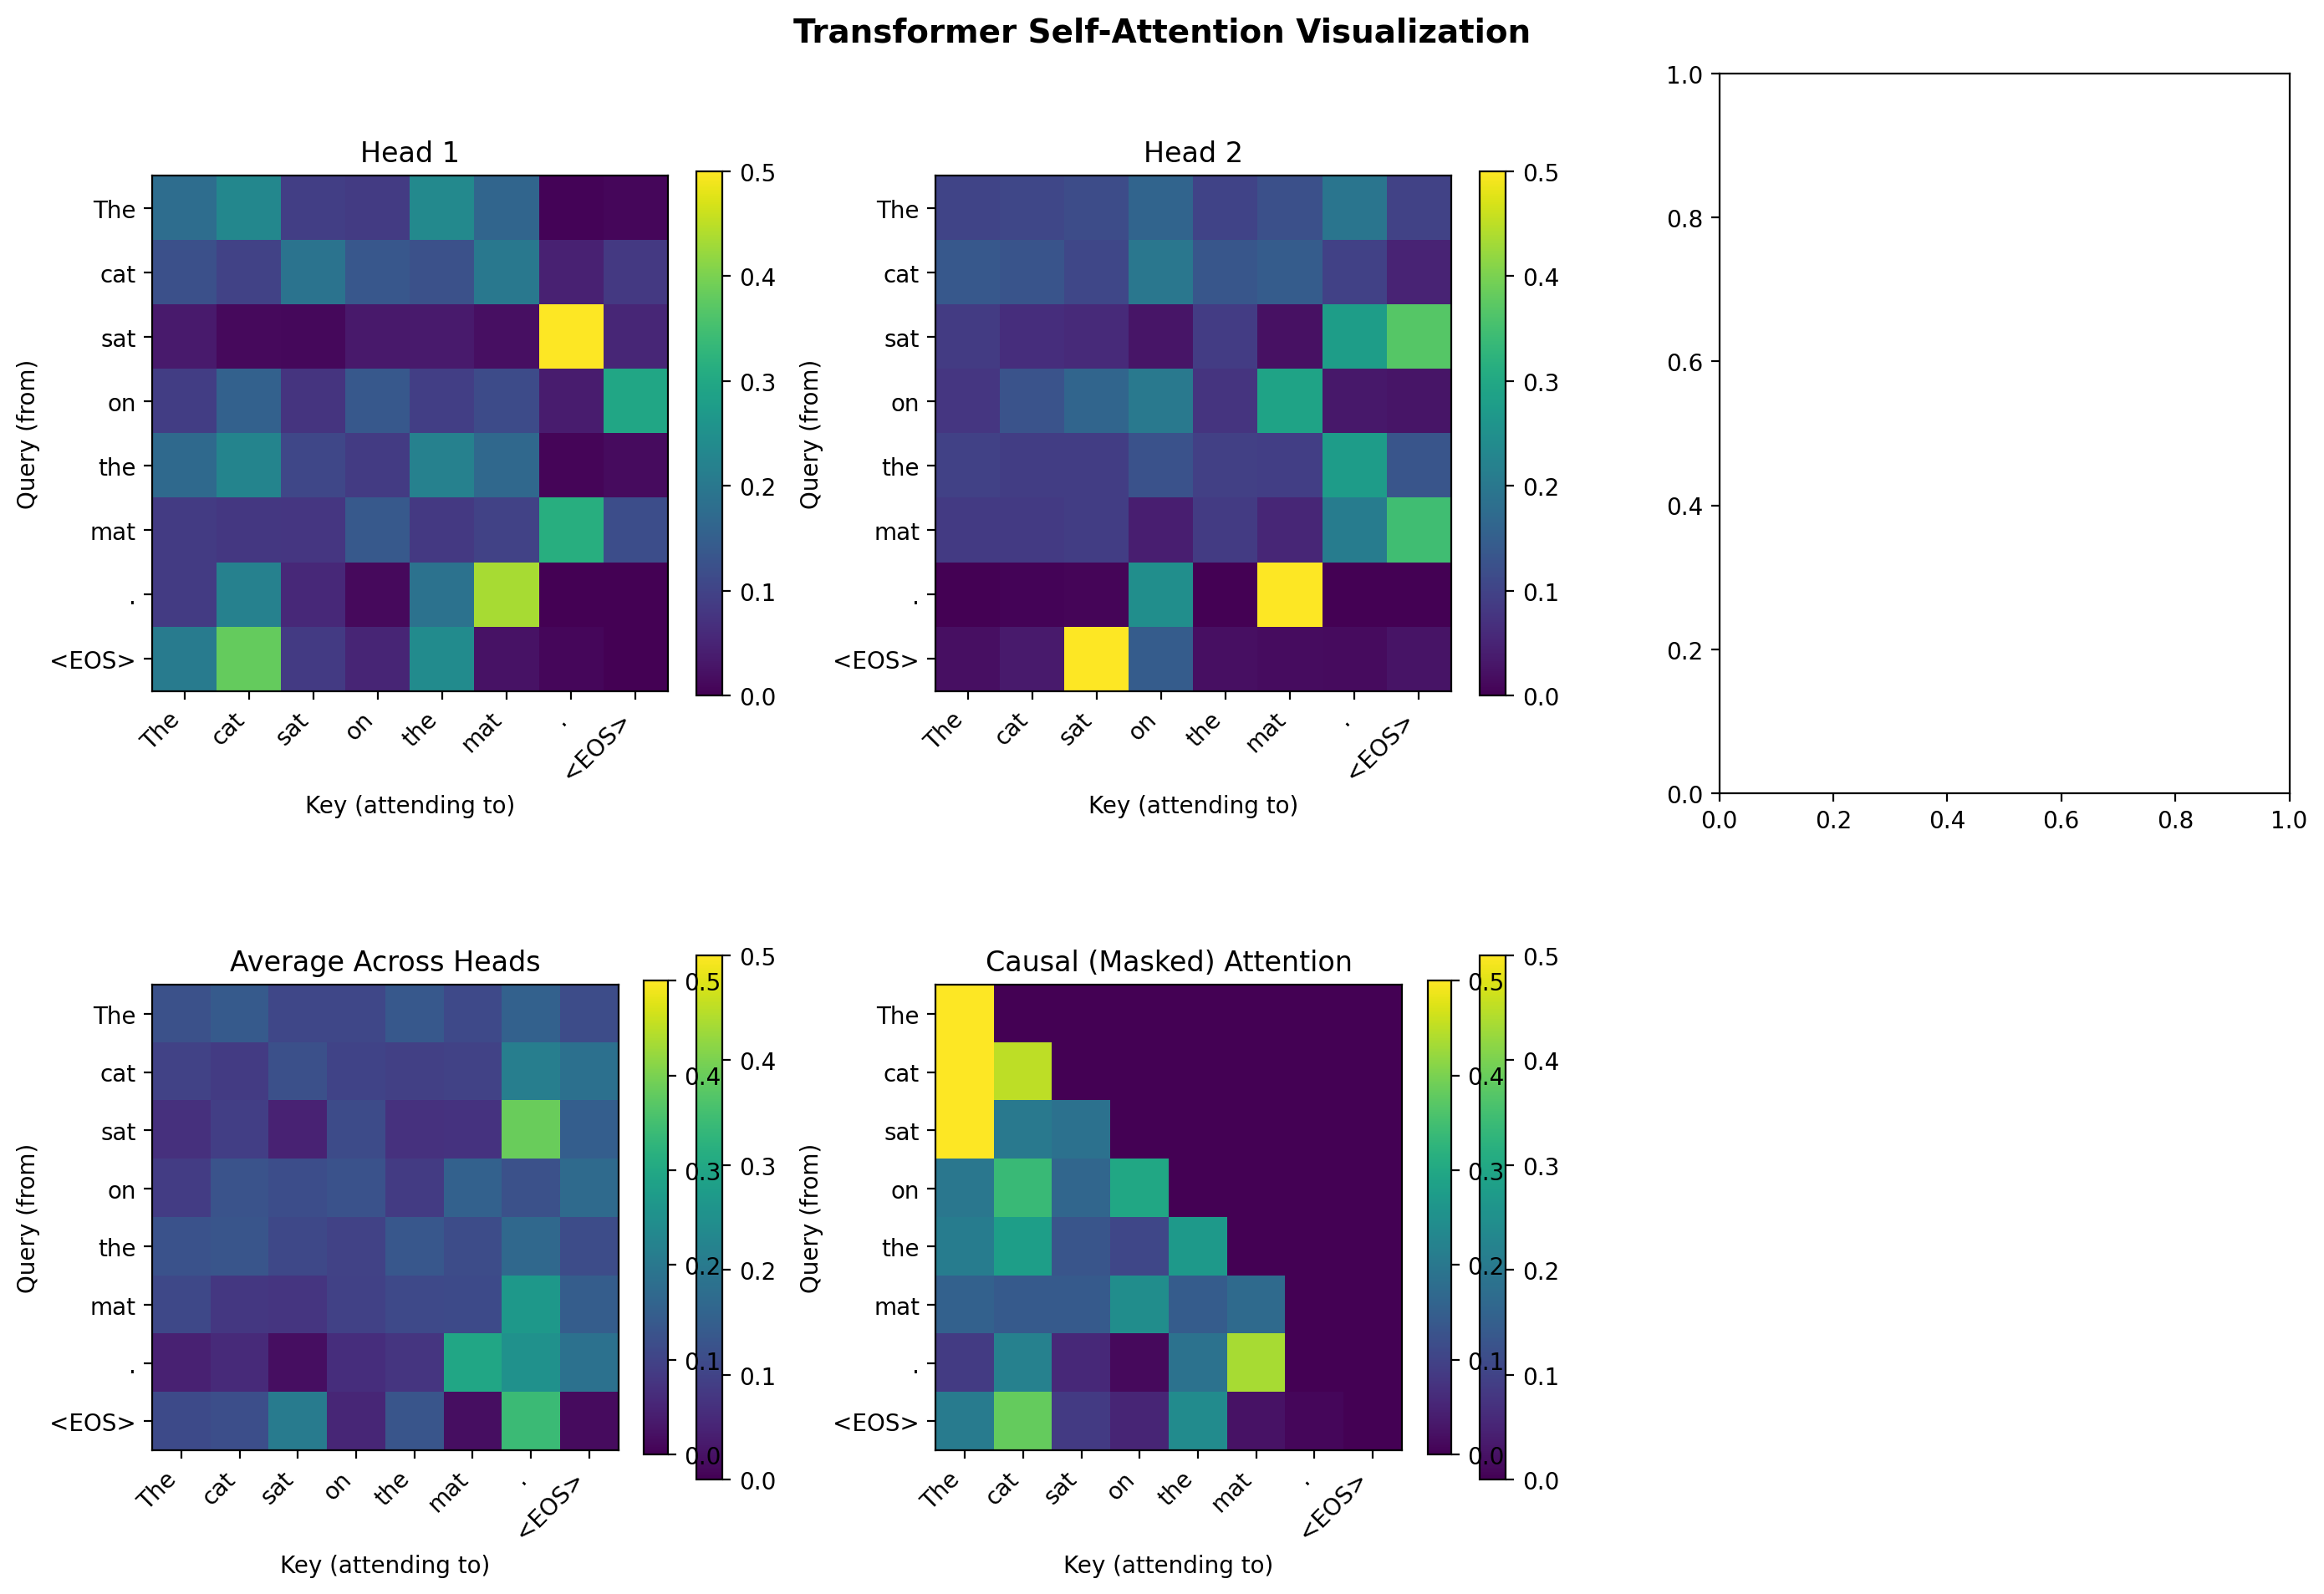


Plot saved to 'plot.png'


In [9]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

# Plot attention weights for each head
for h in range(num_heads):
    row, col = h // 2, h % 2
    ax = axes[row, col]
    im = ax.imshow(attn_weights[0, h], cmap='viridis', vmin=0, vmax=0.5)
    ax.set_xticks(range(seq_len))
    ax.set_yticks(range(seq_len))
    ax.set_xticklabels(tokens, rotation=45, ha='right')
    ax.set_yticklabels(tokens)
    ax.set_xlabel('Key (attending to)')
    ax.set_ylabel('Query (from)')
    ax.set_title(f'Head {h+1}')
    plt.colorbar(im, ax=ax, fraction=0.046)

# Plot average attention across all heads
ax = axes[1, 0]
avg_attn = attn_weights[0].mean(axis=0)
im = ax.imshow(avg_attn, cmap='viridis', vmin=0, vmax=0.5)
ax.set_xticks(range(seq_len))
ax.set_yticks(range(seq_len))
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_yticklabels(tokens)
ax.set_xlabel('Key (attending to)')
ax.set_ylabel('Query (from)')
ax.set_title('Average Across Heads')
plt.colorbar(im, ax=ax, fraction=0.046)

# Plot causal attention pattern
ax = axes[1, 1]
causal_mask = create_causal_mask(seq_len)
_, causal_attn = scaled_dot_product_attention(
    X @ mha.W_Q.reshape(d_model, num_heads, -1)[:, 0, :],
    X @ mha.W_K.reshape(d_model, num_heads, -1)[:, 0, :],
    X @ mha.W_V.reshape(d_model, num_heads, -1)[:, 0, :],
    mask=causal_mask
)
im = ax.imshow(causal_attn[0], cmap='viridis', vmin=0, vmax=0.5)
ax.set_xticks(range(seq_len))
ax.set_yticks(range(seq_len))
ax.set_xticklabels(tokens, rotation=45, ha='right')
ax.set_yticklabels(tokens)
ax.set_xlabel('Key (attending to)')
ax.set_ylabel('Query (from)')
ax.set_title('Causal (Masked) Attention')
plt.colorbar(im, ax=ax, fraction=0.046)

# Remove empty subplot
axes[1, 2].axis('off')

plt.suptitle('Transformer Self-Attention Visualization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('transformer_architecture_attention_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## 7. Positional Encoding

Since attention has no inherent notion of position, Transformers use **positional encodings** to inject sequence order information. The original paper uses sinusoidal encodings:

$$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

$$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{\text{model}}}}\right)$$

where $pos$ is the position and $i$ is the dimension index.

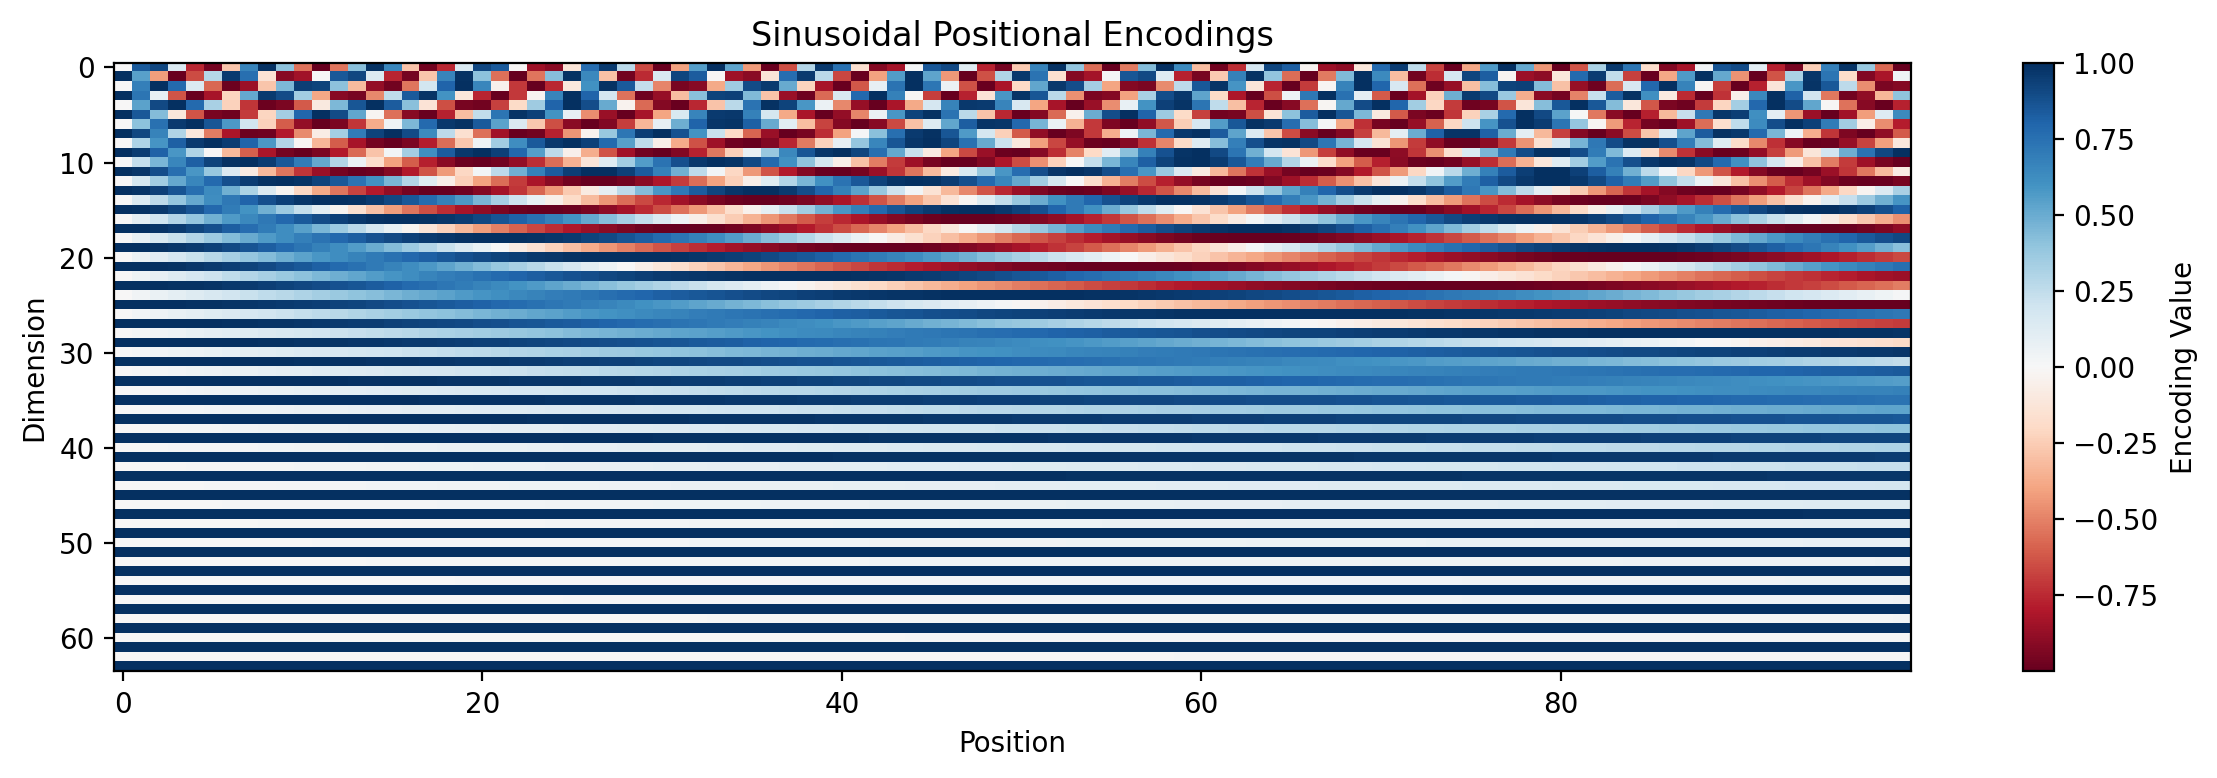

In [10]:
def positional_encoding(max_len, d_model):
    """
    Generate sinusoidal positional encodings.
    
    Parameters:
    -----------
    max_len : int
        Maximum sequence length
    d_model : int
        Model dimension
    
    Returns:
    --------
    PE : ndarray of shape (max_len, d_model)
        Positional encoding matrix
    """
    PE = np.zeros((max_len, d_model))
    position = np.arange(max_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    
    PE[:, 0::2] = np.sin(position * div_term)
    PE[:, 1::2] = np.cos(position * div_term)
    
    return PE

# Generate and visualize positional encodings
max_len = 100
d_model = 64
PE = positional_encoding(max_len, d_model)

plt.figure(figsize=(12, 4))
plt.imshow(PE.T, aspect='auto', cmap='RdBu')
plt.colorbar(label='Encoding Value')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Sinusoidal Positional Encodings')
plt.tight_layout()
plt.show()

## 8. Computational Complexity Analysis

The attention mechanism has complexity:

- **Time complexity**: $O(n^2 \cdot d)$ where $n$ is sequence length and $d$ is dimension
- **Space complexity**: $O(n^2)$ for storing attention weights

This quadratic scaling limits Transformers to sequences of a few thousand tokens. Various efficient attention variants address this (Linear Attention, Sparse Attention, etc.).

Seq length   64: 0.09 ms
Seq length  128: 0.22 ms
Seq length  256: 17.83 ms


Seq length  512: 96.52 ms


Seq length 1024: 141.22 ms


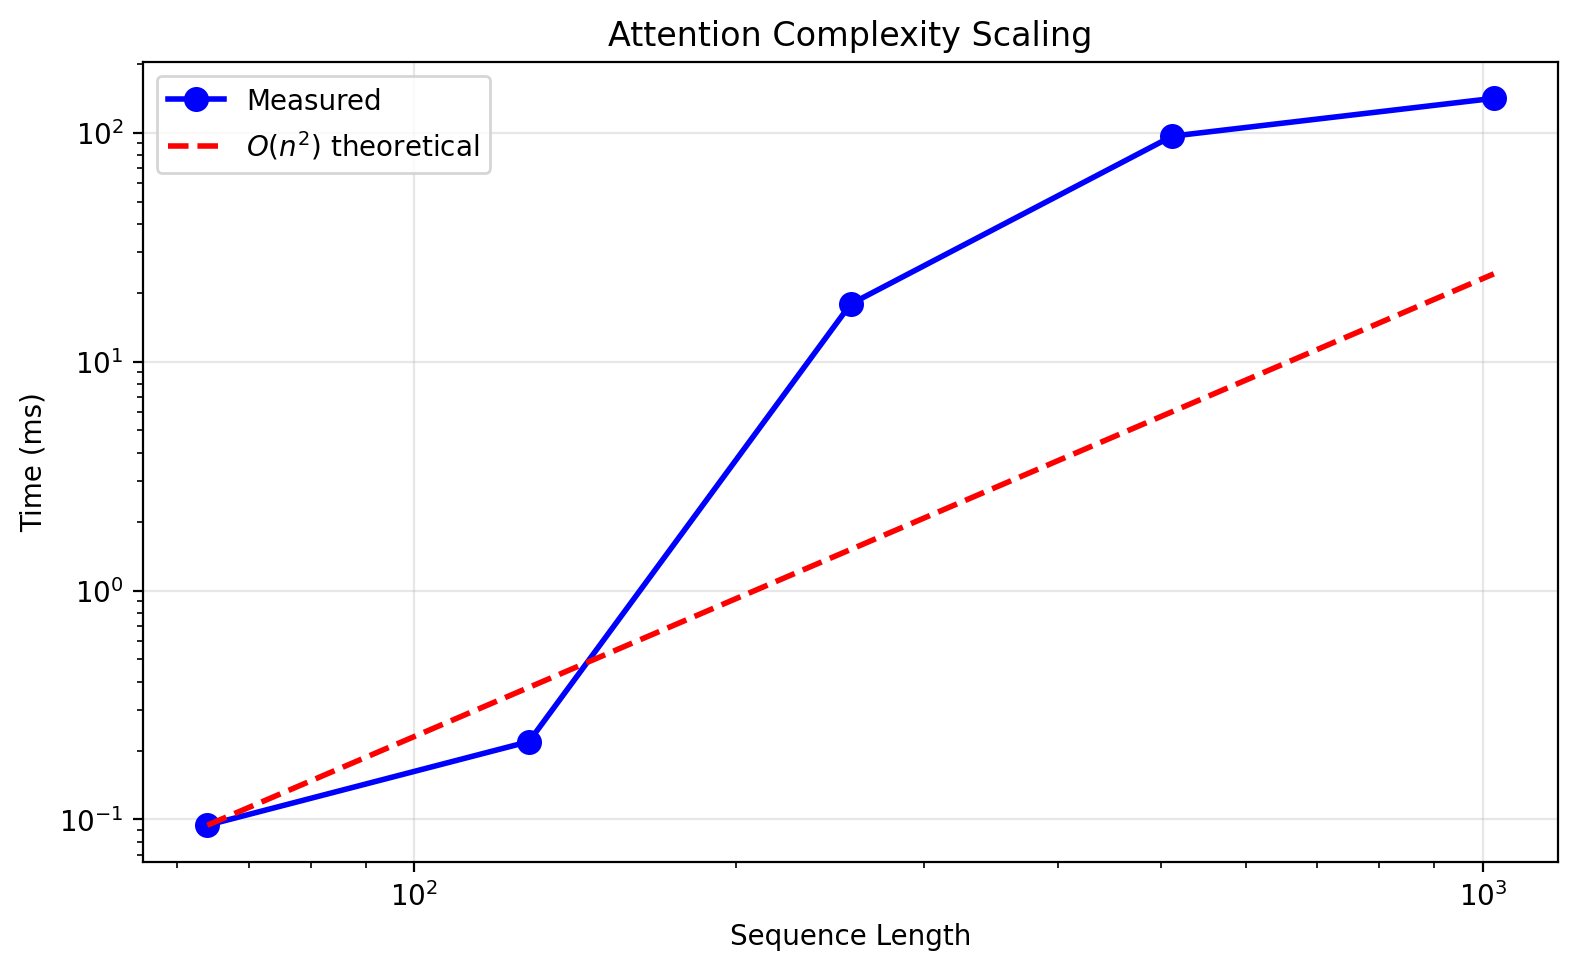

In [11]:
# Demonstrate quadratic scaling
import time

seq_lengths = [64, 128, 256, 512, 1024]
d_model = 64
times = []

for seq_len in seq_lengths:
    Q = np.random.randn(1, seq_len, d_model)
    K = np.random.randn(1, seq_len, d_model)
    V = np.random.randn(1, seq_len, d_model)
    
    start = time.time()
    for _ in range(10):
        _, _ = scaled_dot_product_attention(Q, K, V)
    elapsed = (time.time() - start) / 10
    times.append(elapsed * 1000)  # Convert to ms
    print(f"Seq length {seq_len:4d}: {elapsed*1000:.2f} ms")

# Plot scaling behavior
plt.figure(figsize=(8, 5))
plt.loglog(seq_lengths, times, 'bo-', markersize=8, linewidth=2, label='Measured')

# Theoretical O(n^2) curve
theoretical = [times[0] * (n/seq_lengths[0])**2 for n in seq_lengths]
plt.loglog(seq_lengths, theoretical, 'r--', linewidth=2, label=r'$O(n^2)$ theoretical')

plt.xlabel('Sequence Length')
plt.ylabel('Time (ms)')
plt.title('Attention Complexity Scaling')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Summary

This notebook covered the essential components of the Transformer attention mechanism:

1. **Scaled Dot-Product Attention**: The fundamental operation computing weighted sums of values based on query-key compatibility

2. **Multi-Head Attention**: Parallel attention operations that allow the model to attend to different representation subspaces

3. **Causal Masking**: Prevents future information leakage in autoregressive models

4. **Positional Encodings**: Inject position information into the position-agnostic attention mechanism

5. **Computational Complexity**: Quadratic $O(n^2)$ scaling with sequence length

### Key Equations

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O$$

The attention mechanism's ability to capture long-range dependencies in a single operation, combined with parallelizability, makes Transformers the dominant architecture for sequence modeling tasks.

## References

1. Vaswani, A., et al. (2017). *Attention Is All You Need*. NeurIPS.
2. Devlin, J., et al. (2019). *BERT: Pre-training of Deep Bidirectional Transformers*. NAACL.
3. Brown, T., et al. (2020). *Language Models are Few-Shot Learners*. NeurIPS.